# Aji Saka's Writings - (ꦲꦤꦕꦫꦏ - ꦣꦠꦱꦮꦭ - ꦥꦣꦗꦪꦚ - ꦩꦒꦧꦛꦔ) - Javanese Aksara

Kernel:
- CPU: 4 cores
- RAM: 16GB
- GPU: Nvidia L4 24GB

### Installing Libraries

In [1]:
%uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%uv pip install optuna timm opencv-python matplotlib scikit-learn pytesseract kaggle

Using Python 3.12.6 environment at: /usr/local
Audited 3 packages in 33ms
Note: you may need to restart the kernel to use updated packages.
Using Python 3.12.6 environment at: /usr/local
Resolved 76 packages in 575ms
⠙ Preparing packages... (0/20)
⠙ Preparing packages... (0/20)
⠙ Preparing packages... (0/20)
python-slugify ------------------------------ 9.82 KiB/9.82 KiB
⠙ Preparing packages... (0/20)
python-slugify ------------------------------ 9.82 KiB/9.82 KiB
⠙ Preparing packages... (0/20)
python-slugify ------------------------------ 9.82 KiB/9.82 KiB
pytesseract ------------------------------ 14.36 KiB/14.36 KiB
⠙ Preparing packages... (0/20)
python-slugify ------------------------------ 9.82 KiB/9.82 KiB
pytesseract ------------------------------ 14.36 KiB/14.36 KiB
⠙ Preparing packages... (0/20)
mypy-extensions ------------------------------     0 B/4.85 KiB
python-slugify ------------------------------ 9.82 KiB/9.82 KiB
pytesseract ------------------------------ 14.36 KiB/14.

### Download Dataset

In [1]:
!kaggle datasets download -d vzrenggamani/hanacaraka --force

Dataset URL: https://www.kaggle.com/datasets/vzrenggamani/hanacaraka
License(s): ODC Public Domain Dedication and Licence (PDDL)
  0%|                                               | 0.00/9.20M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 9.20M/9.20M [00:00<00:00, 671MB/s]


### Extract Dataset

In [2]:
import zipfile

zip_path = "/root/hanacaraka.zip"
extract_to = "/root/data"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_to)

## Import Required Libraries & Configurations

In [3]:
import os
import cv2
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageFile
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Hyperparameter Tuning
import optuna

# Check Device & Setup Mixed Precision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# Random Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

# Allow PIL to handle truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using Device: cuda
GPU Name: NVIDIA L4


## Data Loading - Split (70% Train, 15% Val, 15% Test) - Preprocessing Images

In [4]:
DATASET_ROOT = '/root/data' 
IMG_SIZE = 224
BATCH_SIZE = 32

def scan_and_clean_dataset(root_dir):
    valid_paths = []
    valid_labels = []
    
    if not os.path.exists(root_dir):
        print(f"Error: Path {root_dir} does not exist.")
        return [], [], [], {}

    classes = sorted(os.listdir(root_dir))
    classes = [c for c in classes if os.path.isdir(os.path.join(root_dir, c))]
    
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}

    print(f"Scanning {len(classes)} classes...")

    for cls_name in classes:
        cls_folder = os.path.join(root_dir, cls_name)
        files = os.listdir(cls_folder)
        for img_name in files:
            img_path = os.path.join(cls_folder, img_name)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                try:
                    with Image.open(img_path) as img:
                        img.verify() # Check for corruption
                    valid_paths.append(img_path)
                    valid_labels.append(class_to_idx[cls_name])
                except:
                    pass # Skip corrupt files

    return valid_paths, valid_labels, classes, idx_to_class

def get_weighted_sampler(labels):
    class_counts = Counter(labels)
    total_samples = len(labels)
    
    # Calculate weights (Inverse Frequency)
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in labels]
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class AksaraDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.file_paths)
    def __getitem__(self, idx):
        try:
            img = Image.open(self.file_paths[idx]).convert('RGB')
        except:
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0, 0, 0))
        if self.transform: img = self.transform(img)
        return img, torch.tensor(self.labels[idx], dtype=torch.long)

all_files, all_labels, class_names, idx_to_class = scan_and_clean_dataset(DATASET_ROOT)

if len(all_files) > 0:
    # Split
    X_train, X_temp, y_train, y_temp = train_test_split(all_files, all_labels, test_size=0.3, stratify=all_labels, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    print(f"Training Set:   {len(X_train)} images")
    print(f"Validation Set: {len(X_val)} images")
    print(f"Test Set:       {len(X_test)} images")
    print(f"Total Clean:    {len(all_files)} images")

    # Datasets
    train_ds = AksaraDataset(X_train, y_train, transform=train_transforms)
    val_ds = AksaraDataset(X_val, y_val, transform=val_test_transforms)
    test_ds = AksaraDataset(X_test, y_test, transform=val_test_transforms)

    # Sampler
    train_sampler = get_weighted_sampler(y_train)

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=False, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    
    print(f"\nPipeline Ready & Balanced")
else:
    print("No Image Found")

Scanning 20 classes...
Training Set:   1093 images
Validation Set: 234 images
Test Set:       235 images
Total Clean:    1562 images

Pipeline Ready & Balanced


## Modeling - Stacked Pretrained Models (ResNet50, EfficientNetB0, MobileNetV3) - Meta Learner: Neural Network

In [5]:
class StackedEnsembleModel(nn.Module):
    def __init__(self, num_classes, meta_hidden_units=512, dropout_rate=0.3):
        super(StackedEnsembleModel, self).__init__()
        
        # 1. Backbone: MobileNetV2
        self.mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        self.mobilenet.classifier = nn.Identity() # Remove head
        # Output features: 1280
        
        # 2. Backbone: ResNet50
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Identity() # Remove head
        # Output features: 2048
        
        # 3. Backbone: EfficientNet B0
        self.efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.efficientnet.classifier = nn.Identity() # Remove head
        # Output features: 1280
        
        # Calculate Total Features for Concatenation
        # 1280 (MobileNet) + 2048 (ResNet) + 1280 (EfficientNet) = 4608
        self.total_features = 1280 + 2048 + 1280
        
        # 4. Meta-Learner (MLP Head)
        self.meta_learner = nn.Sequential(
            nn.Linear(self.total_features, meta_hidden_units),
            nn.BatchNorm1d(meta_hidden_units),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(meta_hidden_units, num_classes)
        )
        
    def forward(self, x):
        # Extract features from backbones
        f1 = self.mobilenet(x)
        f2 = self.resnet(x)
        f3 = self.efficientnet(x)
        
        # Concatenate features
        combined_features = torch.cat((f1, f2, f3), dim=1)
        
        # Pass through Meta-Learner
        output = self.meta_learner(combined_features)
        return output

# Test Model Instantiation
model_test = StackedEnsembleModel(num_classes=len(class_names)).to(device)
print(model_test)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|█████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 77.5MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|█████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 64.0MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 68.1MB/s]


StackedEnsembleModel(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, ker

## Hyperparameter Tuning - Tree Parzen Estimator

In [6]:
import torch.cuda.amp as amp

def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed Precision Forward Pass
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Scaled Backward Pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return running_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(loader), 100 * correct / total

# Optuna objective
def objective(trial):
    # 1. Suggest Hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    hidden_units = trial.suggest_categorical('hidden_units', [256, 512, 1024])
    
    # 2. Build Model
    model = StackedEnsembleModel(num_classes=len(class_names), 
                                 meta_hidden_units=hidden_units, 
                                 dropout_rate=dropout).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler('cuda')
    
    # 3. Short Training Loop (e.g., 5 epochs for tuning)
    # Note: Ensure `train_loader` and `val_loader` are defined before running this
    for epoch in range(3): 
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        # Pruning (Stop bad trials early)
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return val_acc # Maximize Accuracy

# Run Optuna (Uncomment to run)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print("Best params:", study.best_params)

[I 2025-11-22 07:31:28,782] A new study created in memory with name: no-name-4b4de146-9238-4972-84fe-e4c4262f56e6
[I 2025-11-22 07:32:22,913] Trial 0 finished with value: 87.6068376068376 and parameters: {'lr': 0.000109409669363483, 'dropout': 0.3187822096859891, 'hidden_units': 256}. Best is trial 0 with value: 87.6068376068376.
[I 2025-11-22 07:32:48,607] Trial 1 finished with value: 78.63247863247864 and parameters: {'lr': 0.000800002465093264, 'dropout': 0.40863701086573934, 'hidden_units': 256}. Best is trial 0 with value: 87.6068376068376.
[I 2025-11-22 07:33:15,034] Trial 2 finished with value: 81.19658119658119 and parameters: {'lr': 4.41029306797788e-05, 'dropout': 0.3245757609828503, 'hidden_units': 1024}. Best is trial 0 with value: 87.6068376068376.
[I 2025-11-22 07:33:42,503] Trial 3 finished with value: 91.45299145299145 and parameters: {'lr': 0.0005658311150690347, 'dropout': 0.21785824366012924, 'hidden_units': 256}. Best is trial 3 with value: 91.45299145299145.
[I 202

Best params: {'lr': 0.0005658311150690347, 'dropout': 0.21785824366012924, 'hidden_units': 256}


Starting Full Training...
Epoch 1/30 | Train Loss: 2.0903 Acc: 37.97% | Val Loss: 1.5823 Acc: 55.98% | Time: 8.6s
Epoch 2/30 | Train Loss: 0.9895 Acc: 75.57% | Val Loss: 0.5753 Acc: 82.05% | Time: 8.6s
Epoch 3/30 | Train Loss: 0.6099 Acc: 86.92% | Val Loss: 0.8101 Acc: 76.50% | Time: 8.7s
Epoch 4/30 | Train Loss: 0.4733 Acc: 90.48% | Val Loss: 0.5382 Acc: 83.76% | Time: 8.7s
Epoch 5/30 | Train Loss: 0.4171 Acc: 89.94% | Val Loss: 0.4312 Acc: 88.89% | Time: 8.6s
Epoch 6/30 | Train Loss: 0.4107 Acc: 90.76% | Val Loss: 0.3319 Acc: 89.74% | Time: 8.5s
Epoch 7/30 | Train Loss: 0.2867 Acc: 94.51% | Val Loss: 0.4005 Acc: 87.18% | Time: 8.6s
Epoch 8/30 | Train Loss: 0.2841 Acc: 92.68% | Val Loss: 0.2799 Acc: 93.59% | Time: 8.7s
Epoch 9/30 | Train Loss: 0.3328 Acc: 91.49% | Val Loss: 0.3870 Acc: 87.61% | Time: 8.6s
Epoch 10/30 | Train Loss: 0.2820 Acc: 93.23% | Val Loss: 0.3088 Acc: 91.88% | Time: 8.7s
Epoch 11/30 | Train Loss: 0.2316 Acc: 94.33% | Val Loss: 0.2557 Acc: 92.31% | Time: 8.7s
Epoc

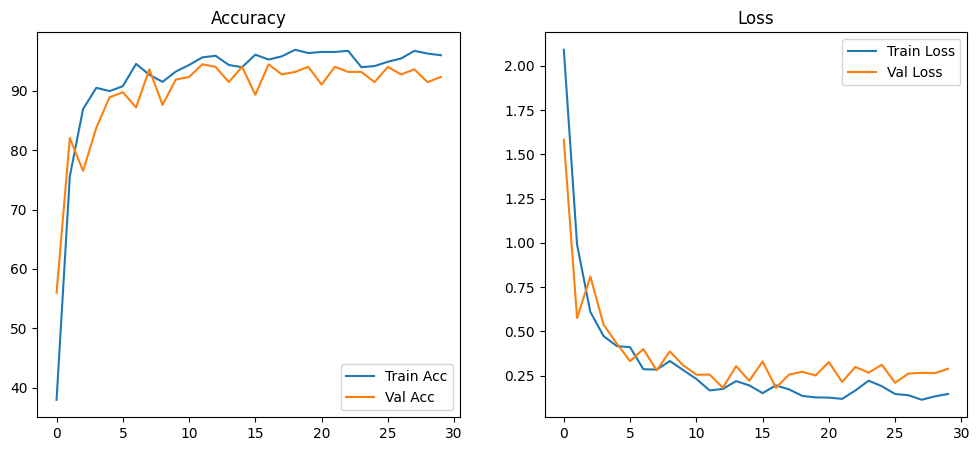

In [7]:
# Use Best Params from Optuna (Example values)
best_params = study.best_params

final_model = StackedEnsembleModel(num_classes=len(class_names), 
                                   meta_hidden_units=best_params['hidden_units'], 
                                   dropout_rate=best_params['dropout']).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(final_model.parameters(), lr=best_params['lr'])
scaler = torch.amp.GradScaler('cuda')

EPOCHS = 30
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting Full Training...")
for epoch in range(EPOCHS):
    start_time = time.time()
    
    t_loss, t_acc = train_one_epoch(final_model, train_loader, optimizer, criterion, scaler)
    v_loss, v_acc = validate(final_model, val_loader, criterion)
    
    history['train_loss'].append(t_loss)
    history['train_acc'].append(t_acc)
    history['val_loss'].append(v_loss)
    history['val_acc'].append(v_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {t_loss:.4f} Acc: {t_acc:.2f}% | "
          f"Val Loss: {v_loss:.4f} Acc: {v_acc:.2f}% | "
          f"Time: {time.time()-start_time:.1f}s")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

## Evaluation and Model Prediction

              precision    recall  f1-score   support

          ba       0.86      1.00      0.92        12
          ca       1.00      0.83      0.91        12
          da       0.92      1.00      0.96        12
         dha       1.00      0.45      0.62        11
          ga       0.90      0.82      0.86        11
          ha       0.90      0.75      0.82        12
          ja       1.00      1.00      1.00        11
          ka       0.80      1.00      0.89        12
          la       1.00      1.00      1.00        12
          ma       0.92      0.92      0.92        12
          na       1.00      1.00      1.00        12
         nga       0.92      0.92      0.92        12
         nya       1.00      0.91      0.95        11
          pa       0.92      1.00      0.96        12
          ra       1.00      1.00      1.00        11
          sa       1.00      1.00      1.00        12
          ta       0.86      1.00      0.92        12
         tha       1.00    

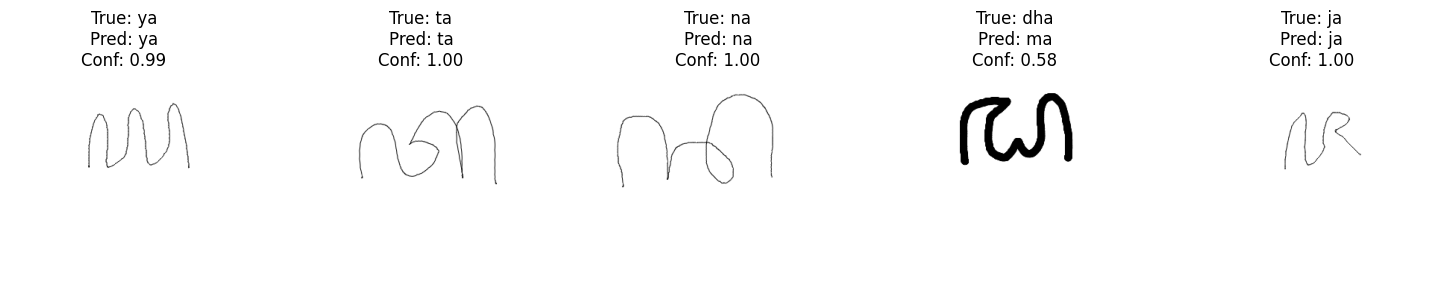

In [9]:
def predict_aksara_ocr(model, image_path):
    """
    Uses the trained Stacked Model to perform 'OCR' (Image Classification)
    Returns the predicted text (transliteration).
    """
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_tensor = val_test_transforms(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted_idx = torch.max(probs, 1)
    
    predicted_char = idx_to_class[predicted_idx.item()]
    return predicted_char, confidence.item(), img

# Evaluation on Test Set
y_true = []
y_pred = []

final_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = final_model(images)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

# Visual OCR Demo
# Pick random samples from test set
import random
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
indices = random.sample(range(len(X_test)), 5)

for i, idx in enumerate(indices):
    path = X_test[idx]
    true_label = idx_to_class[y_test[idx]]
    
    pred_char, conf, img = predict_aksara_ocr(final_model, path)
    
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_char}\nConf: {conf:.2f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## OCR (Optical Character Recognition) Process

In [10]:
import zipfile

zip_path = "/root/data/test_ocr.zip"
extract_to = "/root/data"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_to)

Found 4 images. Starting Batch OCR...
Processed datasawala.jpeg: da la ca ra la
Processed hanacaraka.jpeg: kaha ka ca ja ka
Processed magabathanga.jpeg: ga ga dhadha jawa rawa
Processed padhajayanya.jpeg: ha dha ja ya raga


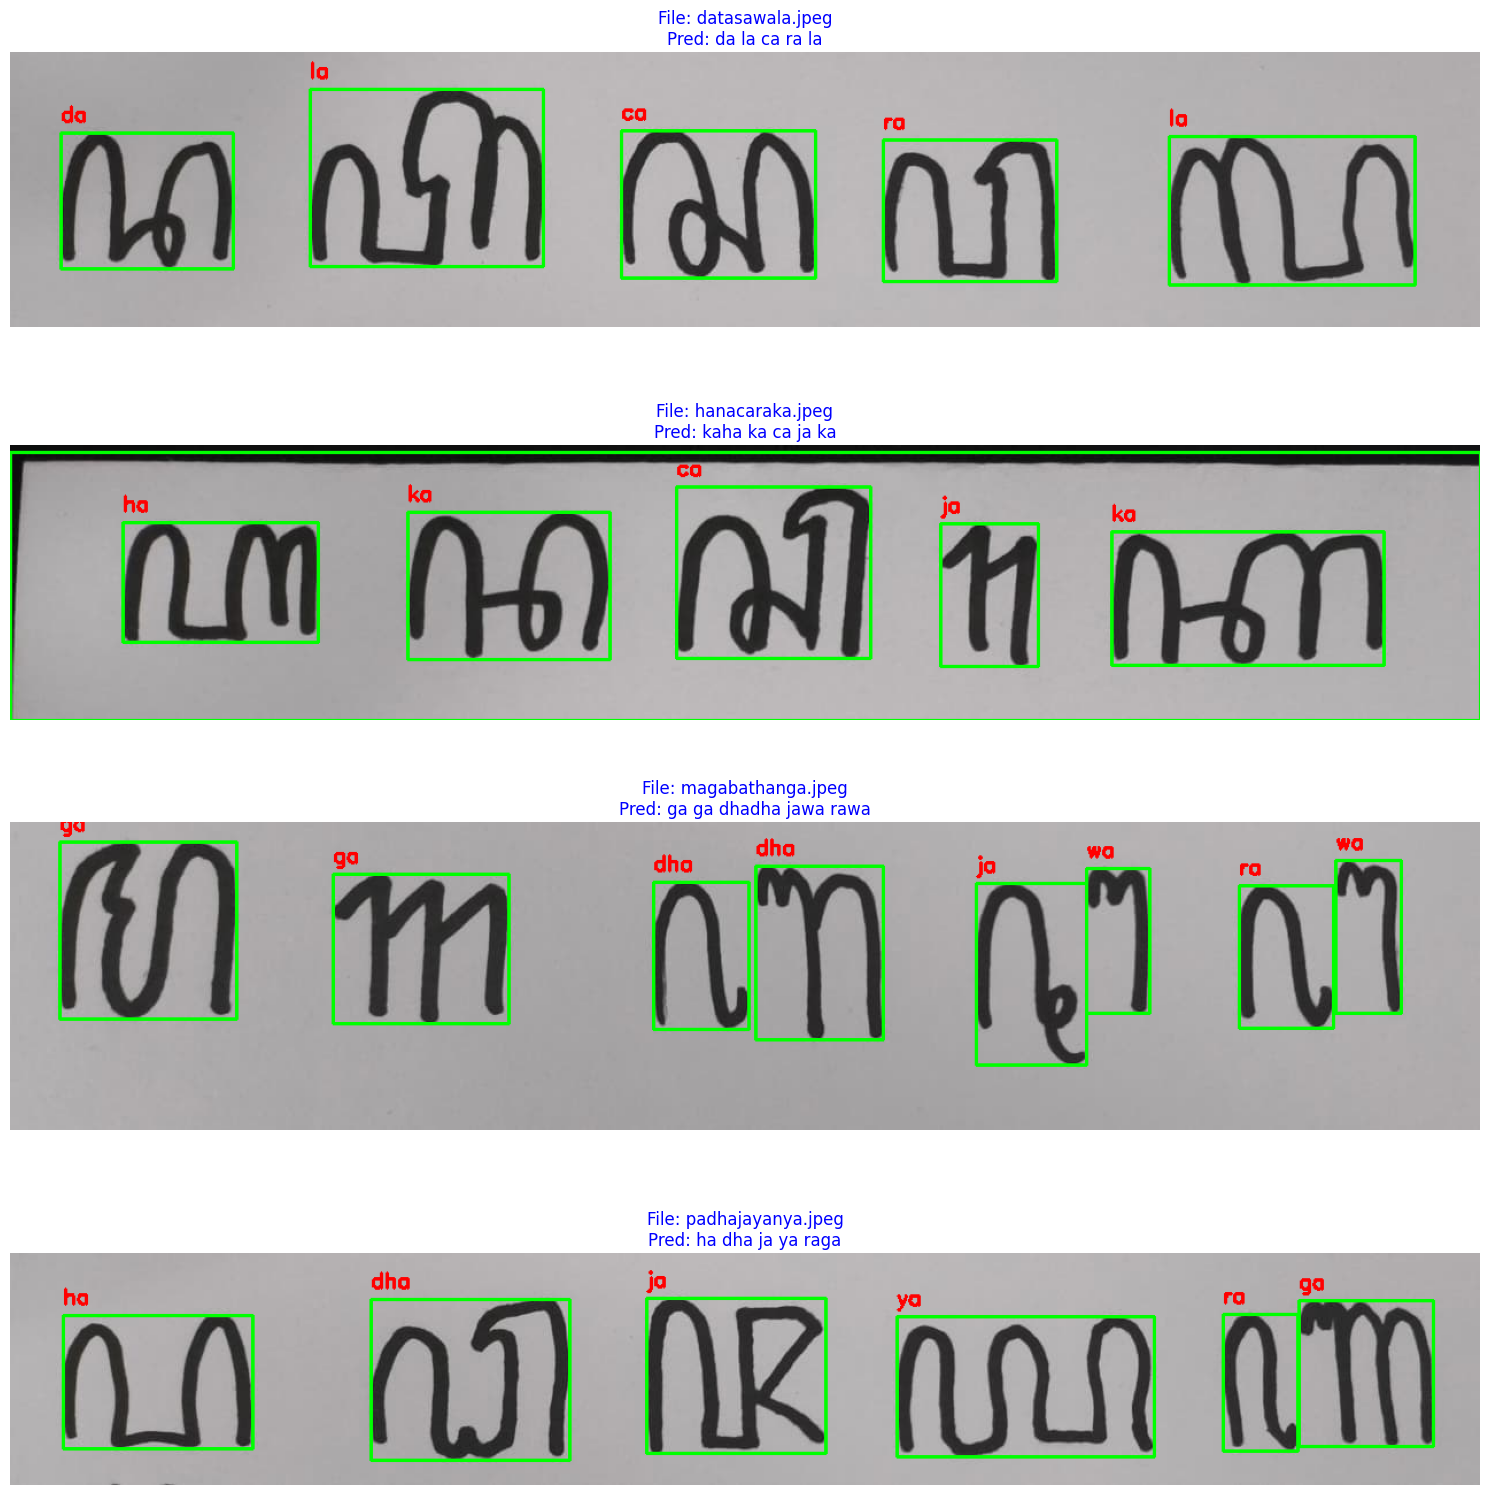

Results:
         Filename         Predicted Text
  datasawala.jpeg         da la ca ra la
  hanacaraka.jpeg       kaha ka ca ja ka
magabathanga.jpeg ga ga dhadha jawa rawa
padhajayanya.jpeg      ha dha ja ya raga


In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2

class OCRProcessor:
    """
    Handles the end-to-end OCR process: 
    Image Segmentation -> Preprocessing -> Model Inference -> Text Reconstruction.
    """
    def __init__(self, model, class_names, device):
        """
        Args:
            model (nn.Module): The trained StackedEnsembleModel.
            class_names (list): List of class labels (idx_to_class).
            device (torch.device): 'cuda' or 'cpu'.
        """
        self.model = model
        self.class_names = class_names
        self.device = device
        self.model.eval()
        
        # Transform for the model input (Must match training transform)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def preprocess_crop(self, crop_img):
        """
        Converts a raw OpenCV crop (numpy) into a Model-ready Tensor.
        Includes 'Letterbox' padding to maintain aspect ratio.
        """
        # 1. Convert BGR to RGB
        img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        
        # 2. Letterbox Padding (Make it square)
        h, w = img.shape[:2]
        target_size = 224
        
        scale = min(target_size/h, target_size/w)
        new_h, new_w = int(h * scale), int(w * scale)
        
        resized = cv2.resize(img, (new_w, new_h))
        
        # Create a black canvas (or white, depending on training data background)
        # Assuming training data was standard images, we use black padding or white.
        # If training data is white bg, use (255,255,255). If black bg, use (0,0,0).
        # We use black (0) here as default padding.
        canvas = np.zeros((target_size, target_size, 3), dtype=np.uint8)
        
        # Center the image
        y_off = (target_size - new_h) // 2
        x_off = (target_size - new_w) // 2
        canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized
        
        # 3. To Tensor & Normalize
        pil_img = Image.fromarray(canvas)
        tensor = self.transform(pil_img).unsqueeze(0) # Add batch dimension
        return tensor.to(self.device)

    def segment_line(self, image_path):
        """
        Detects characters in a line of text using Contour Analysis.
        
        Returns:
            list: Sorted bounding boxes (x, y, w, h).
            image: The original loaded image.
            binary: The thresholded binary image (for debugging).
        """
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Image not found.")
            
        # Grayscale & Blur
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Thresholding (Adaptive is better for varying lighting)
        binary = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 11, 2
        )
        
        # Find Contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        bounding_boxes = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            
            # Filter noise: Ignore very small dots/lines
            if w > 10 and h > 10: 
                bounding_boxes.append((x, y, w, h))
        
        # Sort boxes from Left to Right
        bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])
        
        return bounding_boxes, image, binary

    def recognize_sentence(self, image_path, space_thresh=20):
        """
        Main function to process a full sentence image.
        
        Args:
            image_path (str): Path to image.
            space_thresh (int): Pixel distance between boxes to consider a 'space'.
            
        Returns:
            str: Predicted text.
            plt.Figure: Visualization of detection.
        """
        boxes, original_img, _ = self.segment_line(image_path)
        
        predicted_text = []
        viz_img = original_img.copy()
        
        for i, (x, y, w, h) in enumerate(boxes):
            # 1. Logic to add Space between words
            if i > 0:
                prev_x, prev_y, prev_w, prev_h = boxes[i-1]
                distance = x - (prev_x + prev_w)
                if distance > space_thresh:
                    predicted_text.append(" ")

            # 2. Crop Character
            # Add slight padding to crop to ensure we don't cut edges
            pad = 5
            y1 = max(0, y - pad)
            y2 = min(original_img.shape[0], y + h + pad)
            x1 = max(0, x - pad)
            x2 = min(original_img.shape[1], x + w + pad)
            
            crop = original_img[y1:y2, x1:x2]
            
            # 3. Predict
            input_tensor = self.preprocess_crop(crop)
            with torch.no_grad():
                output = self.model(input_tensor)
                _, pred_idx = torch.max(output, 1)
                char_label = self.class_names[pred_idx.item()]
            
            predicted_text.append(char_label)
            
            # 4. Draw on Visualization
            cv2.rectangle(viz_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(viz_img, char_label, (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
        full_sentence = "".join(predicted_text)
        return full_sentence, viz_img

# Usage Example
# Assuming 'final_model' and 'class_names' exist from previous blocks
ocr_engine = OCRProcessor(final_model, class_names, device)

def batch_process_sentences(folder_path, ocr_engine):
    """
    Iterates through all images in a folder, performs OCR, 
    and returns a DataFrame of results.
    
    Args:
        folder_path (str): Directory containing sentence images.
        ocr_engine (OCRProcessor): Initialized OCR processor instance.
        
    Returns:
        pd.DataFrame: Table containing Filenames and Predicted Text.
    """
    # 1. Validate Folder
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return None
    
    # 2. Get List of Images
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]
    image_files.sort() # Sort to maintain order
    
    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return None
    
    print(f"Found {len(image_files)} images. Starting Batch OCR...")
    
    results = []
    
    # 3. Process Each Image
    # Setup a grid for visualization (Dynamic size based on N images)
    n_images = len(image_files)
    cols = 1
    rows = n_images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    
    # Handle single image case (axes is not a list)
    if n_images == 1: axes = [axes]
    
    for i, filename in enumerate(image_files):
        full_path = os.path.join(folder_path, filename)
        
        try:
            # Run Inference
            predicted_text, viz_img = ocr_engine.recognize_sentence(full_path)
            
            # Store Result
            results.append({
                "Filename": filename,
                "Predicted Text": predicted_text
            })
            
            # Visualize
            ax = axes[i]
            ax.imshow(cv2.cvtColor(viz_img, cv2.COLOR_BGR2RGB))
            ax.set_title(f"File: {filename}\nPred: {predicted_text}", fontsize=12, color='blue')
            ax.axis('off')
            
            print(f"Processed {filename}: {predicted_text}")
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            results.append({"Filename": filename, "Predicted Text": "ERROR"})
    
    plt.tight_layout()
    plt.show()
    
    # 4. Return Structured Data
    df = pd.DataFrame(results)
    return df
    
# Update this path to the folder containing your 6 sentence images
SENTENCE_FOLDER = '/root/data/test_ocr'  # <--- UPDATE THIS

# Run Batch Processing
if os.path.exists(SENTENCE_FOLDER):
    df_results = batch_process_sentences(SENTENCE_FOLDER, ocr_engine)
    
    if df_results is not None:
        print("Results:")
        print(df_results.to_string(index=False))
        
        # Optional: Save to CSV
        # df_results.to_csv("ocr_results.csv", index=False)
        # print("\nResults saved to 'ocr_results.csv'")
else:
    print(f"Please create the folder '{SENTENCE_FOLDER}' and upload your images there.")

## OCR Word Accuracy Testing

In [12]:
import difflib
import pandas as pd

ground_truth_data = {
    "hanacaraka.jpeg": "hanacaraka",
    "datasawala.jpeg": "datasawala",
    "padhajayanya.jpeg": "padhajayanya",
    "magabathanga.jpeg": "magabathanga"
}

def evaluate_ocr_metrics(df_results, ground_truth_map):
    """
    Calculates accuracy metrics, IGNORING SPACES and CAPITALIZATION.
    """
    df_eval = df_results.copy()
    
    # Map Ground Truth
    df_eval['Ground Truth'] = df_eval['Filename'].map(ground_truth_map)
    
    # Drop missing ground truth
    if df_eval['Ground Truth'].isnull().any():
        missing = df_eval[df_eval['Ground Truth'].isnull()]['Filename'].tolist()
        print(f"Warning: Missing ground truth for: {missing}")
        df_eval = df_eval.dropna(subset=['Ground Truth'])

    # Helper: Text Cleaner (Removes Spaces)
    def clean_text(text):
        """Removes spaces and converts to lowercase."""
        return str(text).replace(" ", "").lower().strip()

    # Create 'Cleaned' columns for comparison
    df_eval['Cleaned Prediction'] = df_eval['Predicted Text'].apply(clean_text)
    df_eval['Cleaned Truth'] = df_eval['Ground Truth'].apply(clean_text)

    # Metric Functions
    def get_similarity(a, b):
        return difflib.SequenceMatcher(None, a, b).ratio() * 100

    # Calculate Scores on CLEANED text
    df_eval['Char Accuracy (%)'] = df_eval.apply(lambda row: get_similarity(row['Cleaned Prediction'], row['Cleaned Truth']), axis=1)
    df_eval['Exact Match'] = df_eval.apply(lambda row: 1 if row['Cleaned Prediction'] == row['Cleaned Truth'] else 0, axis=1)
    
    # Summary
    total_samples = len(df_eval)
    avg_char_acc = df_eval['Char Accuracy (%)'].mean()
    exact_match_acc = (df_eval['Exact Match'].sum() / total_samples) * 100
    
    print("OCR Accuracy (Spaces Ignored)")
    print(f"Total Samples: {total_samples}")
    print(f"Exact Match Accuracy: {exact_match_acc:.2f}%")
    print(f"Avg Character Similarity: {avg_char_acc:.2f}%")
    
    # Return relevant columns including the cleaned versions
    return df_eval[['Filename', 'Cleaned Prediction', 'Cleaned Truth', 'Char Accuracy (%)', 'Exact Match']]

if 'df_results' in locals() and df_results is not None:
    final_report = evaluate_ocr_metrics(df_results, ground_truth_data)
    
    # Show full table
    pd.set_option('display.max_colwidth', None)
    print(final_report.to_string(index=False))
    
    # Save
    final_report.to_csv("final_ocr_evaluation_no_spaces.csv", index=False)
else:
    print("Error: 'df_results' is missing. Please run Block 8 first.")

OCR Accuracy (Spaces Ignored)
Total Samples: 4
Exact Match Accuracy: 0.00%
Avg Character Similarity: 47.09%
         Filename Cleaned Prediction Cleaned Truth  Char Accuracy (%)  Exact Match
  datasawala.jpeg         dalacarala    datasawala          40.000000            0
  hanacaraka.jpeg       kahakacajaka    hanacaraka          36.363636            0
magabathanga.jpeg gagadhadhajawarawa  magabathanga          40.000000            0
padhajayanya.jpeg      hadhajayaraga  padhajayanya          72.000000            0


## Save the Model

In [13]:
import torch
import os

# 1. Configuration
ARTIFACTS_DIR = "artifacts"
MODEL_NAME = "aksara_jawa_stacked_model.pth"
MODEL_SAVE_PATH = os.path.join(ARTIFACTS_DIR, MODEL_NAME)

# 2. Create Directory
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
print(f"Directory '{ARTIFACTS_DIR}' is ready.")

# 3. Save the State Dictionary
print(f"Saving model to {MODEL_SAVE_PATH}...")
torch.save(final_model.state_dict(), MODEL_SAVE_PATH)
print("Model saved successfully!")

Directory 'artifacts' is ready.
Saving model to artifacts/aksara_jawa_stacked_model.pth...
Model saved successfully!
